In [1]:
%pylab inline

from PyTools import err, binner, nbins
from sklearn.cluster import DBSCAN
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]

if "paper_style" in dir():
    mnorm = 1e9
    od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")
    par_lbs = [r"$\log{M_\star/M\odot}$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
               r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$",
               r"$A_V$", r"$z$"]
    res_lbs = [r"$\Delta\log{M_\star}$", r"$\Delta\left<\log{t_\star}\right>_M$",
               r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star}\right>_M$",
               r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]
    hatching = "/"*15
    gray = "0.3"
    ssag_cl = "0.2"
    sdss_cl = "#F6C141"
    sdss_sg = [sdss_cl, "#E8601C"]
    jpas_cl = "#90C987"
    jpas_sg = [jpas_cl, "#4EB265"]
    spec_cl = "#7BAFDE"
    spec_sg = [spec_cl, "#1965B0"]
    map_col = cm.viridis
else:
    mnorm = 1e8
    od = "images/"
    par_lbs = ["Mass (log/M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [3]:
#READ TABLES

Lfrac = put_FITS_names(genfromtxt("data/RealDeal/lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("data/RealDeal/snr.txt")
Cind = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/set3_catalog.txt", usecols=range(39, 39 + 5), unpack=True)
catalog = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/RealDeal/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

spec_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal7/outs/spec/")+"dynbas_output.log", dtype=None, names=True)
spec_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_SPEC_").replace(".log", ".fit") for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])
x = linspace(8.0, 10.2)
y = linspace(-0.7, 0.4)

In [4]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)

In [5]:
#COMMON QUANTITIES

colors = ["#114477", "#117733", "#771122"]

cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con = (Cind["petroR90_r"][in_spec_ne]/Cind["petroR50_r"][in_spec_ne])
rat = 3./Cind["petroR90_r"][in_spec_ne]
col = cat["u_mag"] - cat["r_mag"]

sfgal = col< 2.22
pagal = col>=2.22

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


In [6]:
print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&all(cat["input_file"]==Cind["input_file"][in_spec_ne])
print "table size:  ", spec_ne.size

tables match? True
table size:   12134


In [7]:
m_p, t_p = binner(spec_ne["M_mod"][pagal], spec_ne["log_t_L_mod"][pagal], "median", 16, rang=(8.8, 12))
m_p, z_p = binner(spec_ne["M_mod"][pagal], spec_ne["log_Z_L_mod"][pagal], "median", 16, rang=(8.8, 12))

m_f, t_f = binner(spec_ne["M_mod"][sfgal], spec_ne["log_t_L_mod"][sfgal], "median", 16, rang=(8.8, 12))
m_f, z_f = binner(spec_ne["M_mod"][sfgal], spec_ne["log_Z_L_mod"][sfgal], "median", 16, rang=(8.8, 12))

print "mean offset for PaGs:", mean((t_p-galtab2[:, 4])[~isnan(t_p)]), mean((z_p-galtab2[:, 1])[~isnan(z_p)])
print "mean offset for SFGs:", mean((t_f-galtab2[:, 4])[~isnan(t_f)]), mean((z_f-galtab2[:, 1])[~isnan(z_f)])

mean offset for PaGs: -0.258409090909 0.193590909091
mean offset for SFGs: -0.612923076923 -0.1515


/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


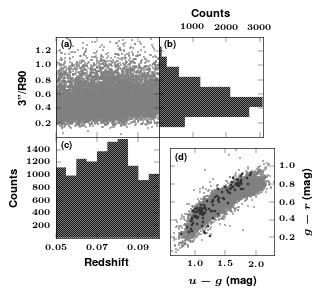

In [8]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
axs[0, 0].text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=axs[0, 0].transAxes)
axs[0, 0].set_xticks(arange(0.05, 0.11, 0.02))
axs[0, 0].set_xlim(0.05, 0.1)
axs[0, 0].set_ylim(0.00, 1.4)
axs[0, 0].set_ylabel(r'\bf 3"/R90')
axs[0, 0].scatter(cat["redshift"], rat, lw=0, c="0.5", s=2)
# ---------------------------------------------------------------------------
axs[0, 1].text(0.05, 0.90, r"\bf (b)", fontsize="small", ha="left", transform=axs[0, 1].transAxes)
axs[0, 1].set_xticks([0, 1000, 2000, 3000, 3500])
rg = axs[0, 1].set_ylim(0.00, 1.4)
axs[0, 1].set_xlabel(r"\bf Counts")
axs[0, 1].hist(rat, 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg,
               orientation="horizontal")
# ---------------------------------------------------------------------------
axs[1, 0].text(0.05, 0.90, r"\bf (c)", fontsize="small", ha="left", transform=axs[1, 0].transAxes)
axs[1, 0].set_xticks(arange(0.05, 0.11, 0.02))
rg = axs[1, 0].set_xlim(0.05, 0.1)
axs[1, 0].set_xlabel(r'\bf Redshift')
axs[1, 0].set_ylabel(r"\bf Counts")
axs[1, 0].hist(cat["redshift"], 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg)
# ---------------------------------------------------------------------------
axs[1, 1].text(0.05, 0.90, r"\bf (d)", fontsize="small", ha="left", transform=axs[1, 1].transAxes)
axs[1, 1].set_xlim(0.6, 2.3)
axs[1, 1].set_ylim(0.0, 1.2)
axs[1, 1].set_xlabel(r"\bf $u-g$ (mag)")
axs[1, 1].set_ylabel(r"\bf $g-r$ (mag)")
axs[1, 1].scatter(cat["u_mag"]-cat["g_mag"], cat["g_mag"]-cat["r_mag"], lw=0, c="0.5", s=2)
axs[1, 1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c="0.2", s=4)
# ---------------------------------------------------------------------------

for ax in axs.ravel():
    if not ax.is_first_col():
        ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(ax.get_yticks()[1:-1])

savefig(od + "sample_chars")

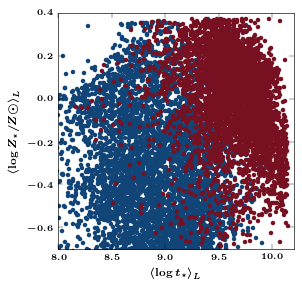

In [9]:
#COMPUTE THE G05 TABLE 2 BINNING (USE AGES FOR BINNING)

xlim(8.0, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

plot(spec_ne["log_t_L_mod"][sfgal], spec_ne["log_Z_L_mod"][sfgal], ".", color=colors[0])
plot(spec_ne["log_t_L_mod"][pagal], spec_ne["log_Z_L_mod"][pagal], ".", color=colors[2])

#savefig("age_met_scatter")

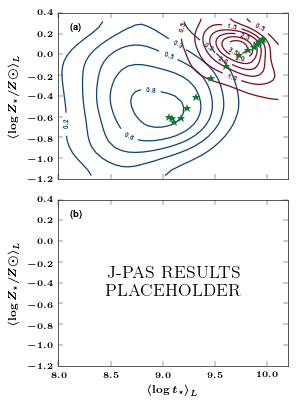

In [10]:
fig, axs = subplots(2, 1, figsize=(3.3, 4.5), sharex=True, sharey=True)

xlim(8.0, 10.2)
ylim(-1.2, 0.4)
axs[1].set_xlabel(par_lbs[2])
axs[0].set_ylabel(par_lbs[4])
axs[1].set_ylabel(par_lbs[4])
axs[0].text(0.05, 0.9, r"\bf (a)", fontsize="small", ha="left", transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, r"\bf (b)", fontsize="small", ha="left", transform=axs[1].transAxes)

nx, xi, xf, bsx = nbins(spec_ne["log_t_L_mod"][sfgal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_L_mod"][sfgal])

H, xe, ye = histogram2d(spec_ne["log_t_L_mod"][sfgal], spec_ne["log_Z_L_mod"][sfgal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["log_t_L_mod"][sfgal], jpas_ne["log_Z_L_mod"][sfgal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)
else:
    axs[1].text(0.5, 0.5, "J-PAS RESULTS\nPLACEHOLDER", fontsize=14, ha="center", va="center", transform=axs[1].transAxes)

nx, xi, xf, bsx = nbins(spec_ne["log_t_L_mod"][pagal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_L_mod"][pagal])

H, xe, ye = histogram2d(spec_ne["log_t_L_mod"][pagal], spec_ne["log_Z_L_mod"][pagal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["log_t_L_mod"][pagal], jpas_ne["log_Z_L_mod"][pagal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

axs[0].plot(galtab2[:, 4], galtab2[:, 1], "*", mfc=colors[1], mec="none")

tight_layout()

savefig(od + "lw_AMR")

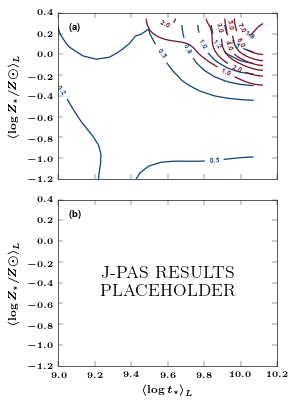

In [11]:
fig, axs = subplots(2, 1, figsize=(3.3, 4.5), sharex=True, sharey=True)

xlim(9.0, 10.2)
ylim(-1.2, 0.4)
axs[1].set_xlabel(par_lbs[2])
axs[0].set_ylabel(par_lbs[4])
axs[1].set_ylabel(par_lbs[4])
axs[0].text(0.05, 0.9, r"\bf (a)", fontsize="small", ha="left", transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, r"\bf (b)", fontsize="small", ha="left", transform=axs[1].transAxes)

nx, xi, xf, bsx = nbins(spec_ne["log_t_M_mod"][sfgal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_M_mod"][sfgal])

H, xe, ye = histogram2d(spec_ne["log_t_M_mod"][sfgal], spec_ne["log_Z_M_mod"][sfgal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["log_t_M_mod"][sfgal], jpas_ne["log_Z_M_mod"][sfgal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

nx, xi, xf, bsx = nbins(spec_ne["log_t_M_mod"][pagal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_M_mod"][pagal])

H, xe, ye = histogram2d(spec_ne["log_t_M_mod"][pagal], spec_ne["log_Z_M_mod"][pagal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["log_t_M_mod"][pagal], jpas_ne["log_Z_M_mod"][pagal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)
else:
    axs[1].text(0.5, 0.5, "J-PAS RESULTS\nPLACEHOLDER", fontsize=14, ha="center", va="center", transform=axs[1].transAxes)

tight_layout()

savefig(od + "mw_AMR")

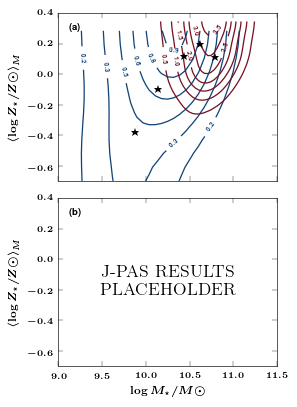

In [12]:
fig, axs = subplots(2, 1, figsize=(3.3, 4.5), sharex=True, sharey=True)

xlim(9, 11.5)
ylim(-0.7, 0.4)
axs[1].set_xlabel(par_lbs[0])
axs[0].set_ylabel(par_lbs[3])
axs[1].set_ylabel(par_lbs[3])
axs[0].text(0.05, 0.9, r"\bf (a)", fontsize="small", ha="left", transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, r"\bf (b)", fontsize="small", ha="left", transform=axs[1].transAxes)

nx, xi, xf, bsx = nbins(spec_ne["M_mod"][sfgal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_M_mod"][sfgal])

H, xe, ye = histogram2d(spec_ne["M_mod"][sfgal], spec_ne["log_Z_M_mod"][sfgal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["M_mod"][sfgal], jpas_ne["log_Z_M_mod"][sfgal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

nx, xi, xf, bsx = nbins(spec_ne["M_mod"][pagal])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_M_mod"][pagal])

H, xe, ye = histogram2d(spec_ne["M_mod"][pagal], spec_ne["log_Z_M_mod"][pagal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

if "jpas_ne" in dir():
    H, xe, ye = histogram2d(jpas_ne["M_mod"][pagal], jpas_ne["log_Z_M_mod"][pagal], bins=(nx, ny), normed=True)
    H = gaussian_filter(H, sigma=3)

    cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

t, m = binner(spec_ne["log_t_L_mod"], spec_ne["M_mod"], "median", nbins=5, rang=(8.5, 10.0))
t, z = binner(spec_ne["log_t_L_mod"], spec_ne["log_Z_M_mod"], "median", nbins=5, rang=(8.5, 10.0))
axs[0].plot(m, z, "*k")

if "jpas_ne" in dir():
    t, m = binner(jpas_ne["log_t_L_mod"], jpas_ne["M_mod"], "median", nbins=5, rang=(8.5, 10.0))
    t, z = binner(jpas_ne["log_t_L_mod"], jpas_ne["log_Z_M_mod"], "median", nbins=5, rang=(8.5, 10.0))
    axs[1].plot(m, z, "*k")
else:
    axs[1].text(0.5, 0.5, "J-PAS RESULTS\nPLACEHOLDER", fontsize=14, ha="center", va="center", transform=axs[1].transAxes)

tight_layout()

savefig(od + "mw_MZR")

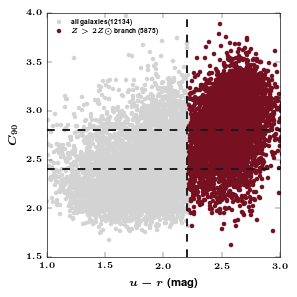

In [13]:
plot(col, con, ".", color="lightgray", label=r"\bf all galaxies (%d)"%con.size)
#plot(col[c1m], con[c1m], ".", color=colors[0], label="~Z$\odot$ branch")
plot(col[pagal], con[pagal], ".", color=colors[2], label=r"\bf $Z>2Z\odot$ branch (%d)"%(sum(pagal)))
legend(loc=2)

axvline(2.2, ls="--", color="0.1", lw=1.5)
axhline(2.4, ls="--", color="0.1", lw=1.5)
axhline(2.8, ls="--", color="0.1", lw=1.5)

xlim(1, 3)
ylim(1.5, 4)
xlabel(r"\bf $u-r$ (mag)")
ylabel(r"\bf $C_{90}$")

tight_layout()